In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pydaptivefiltering as pdf

In [2]:
np.random.seed(123)
n_samples = 2000  # Aumentamos o número de amostras para testar a estabilidade a longo prazo
filter_order = 15

# Sinais puramente REAIS
x = np.random.randn(n_samples)
w_unknown = np.random.uniform(-1, 1, filter_order + 1)

# Gerar sinal desejado com ruído branco
d_clean = np.convolve(x, w_unknown, mode='full')[:n_samples]
d = d_clean + 0.001 * np.random.randn(n_samples)

In [3]:
# Parâmetros sugeridos pelo Diniz (Algoritmo 8.2):
# kappa1=1.5, kappa2=2.5, kappa3=1.0 são valores padrão robustos.
sf_rls = pdf.StabFastRLS(
    filter_order=filter_order,
    forgetting_factor=0.999, # Lambda ligeiramente menor pode ajudar na agilidade
    epsilon=0.1,
    kappa1=1.5,
    kappa2=2.5,
    kappa3=1.0
)

# Rodar otimização
result = sf_rls.optimize(
    input_signal=x, 
    desired_signal=d, 
    verbose=True, 
    return_internal_states=True
)

[StabFastRLS] Completed in 30.90 ms


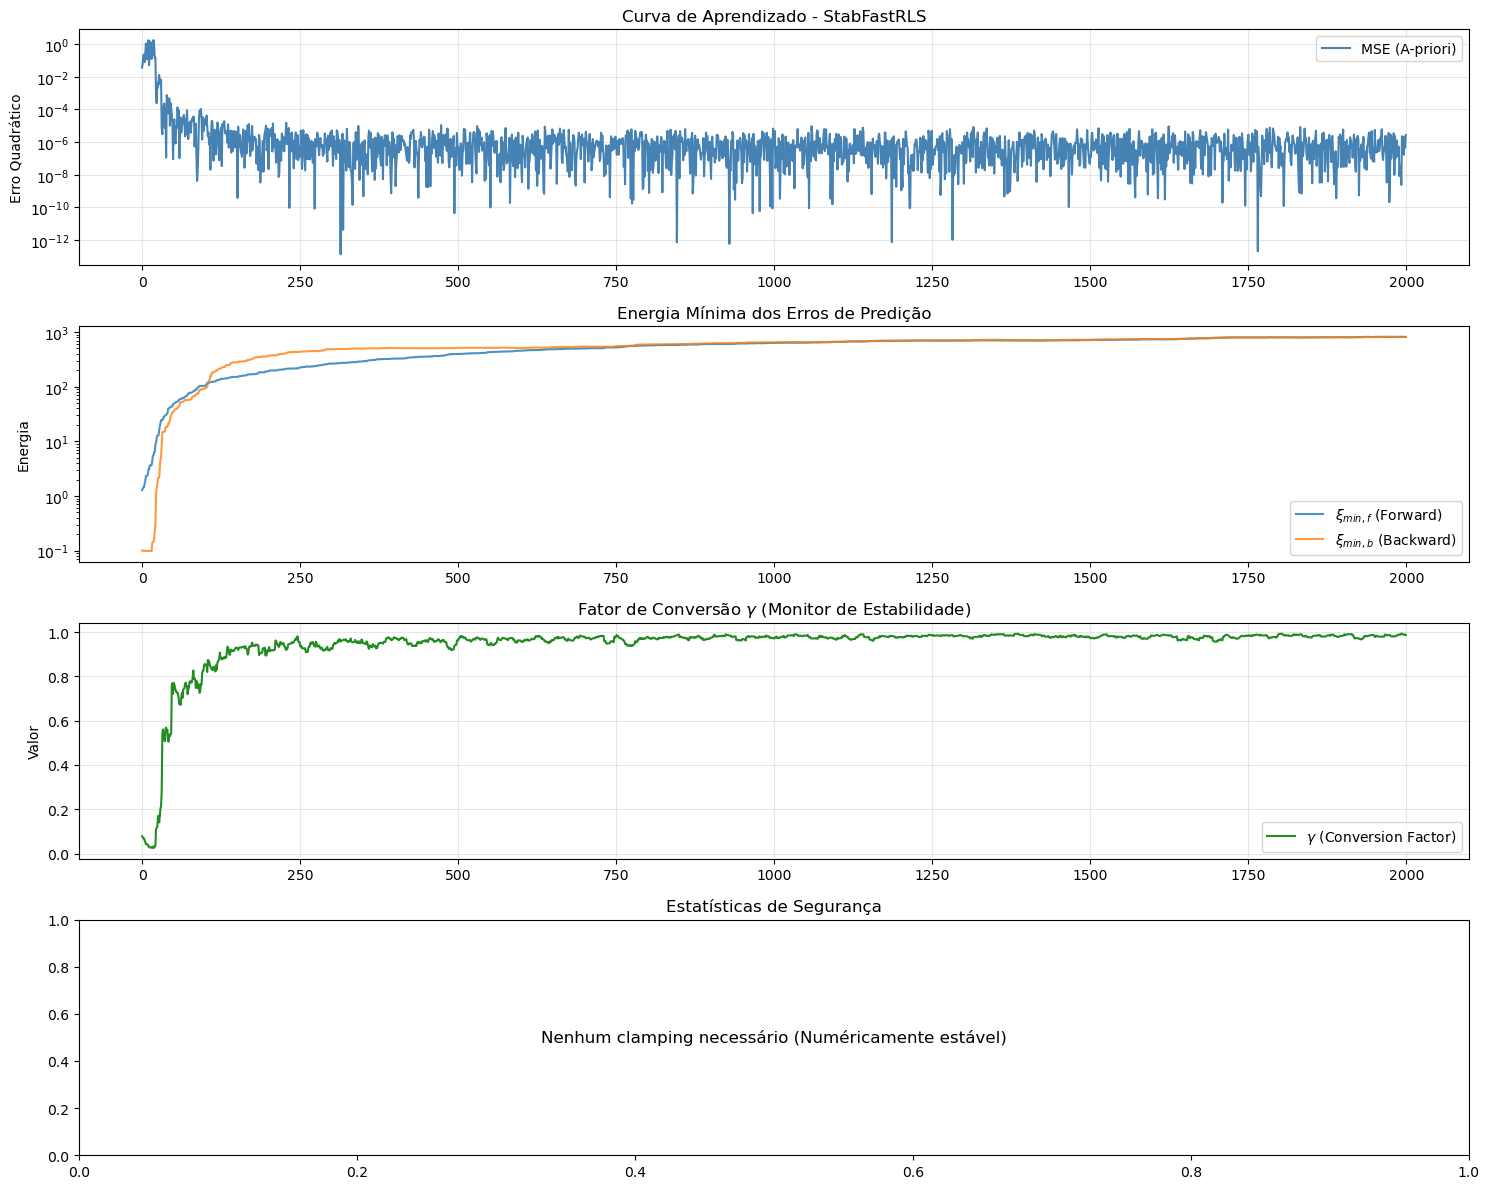

MSD Final: 7.50e-10


In [4]:
# --- ANÁLISE DE RESULTADOS ---

plt.figure(figsize=(15, 12))

# 1. Erro de Identificação (Learning Curve)
plt.subplot(4, 1, 1)
plt.semilogy(result.errors**2, label='MSE (A-priori)', color='steelblue')
plt.title('Curva de Aprendizado - StabFastRLS')
plt.ylabel('Erro Quadrático')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Energia dos Erros de Predição (Forward e Backward)
# No FTRLS comum, se xi_min_b for a zero, o filtro explode. 
# O estabilizado mantém esses valores sob controle.
plt.subplot(4, 1, 2)
if "xi_min_f" in result.extra:
    plt.plot(result.extra["xi_min_f"], label=r'$\xi_{min,f}$ (Forward)', alpha=0.8)
    plt.plot(result.extra["xi_min_b"], label=r'$\xi_{min,b}$ (Backward)', alpha=0.8)
plt.title('Energia Mínima dos Erros de Predição')
plt.ylabel('Energia')
plt.yscale('log')
plt.legend()

# 3. Monitoramento do Fator Gamma
plt.subplot(4, 1, 3)
plt.plot(result.extra["gamma"], color='forestgreen', label=r'$\gamma$ (Conversion Factor)')
plt.title(r'Fator de Conversão $\gamma$ (Monitor de Estabilidade)')
plt.ylabel('Valor')
plt.grid(True, alpha=0.3)
plt.legend()

# 4. Estatísticas de Clamping
# Mostra se o código precisou "segurar" divisões por zero ou valores muito pequenos
plt.subplot(4, 1, 4)
stats = result.extra["clamp_stats"]
if stats:
    keys = list(stats.keys())
    values = list(stats.values())
    plt.bar(keys, values, color='indianred')
    plt.title('Ocorrências de Clamping Numérico (Segurança)')
else:
    plt.text(0.5, 0.5, 'Nenhum clamping necessário (Numéricamente estável)', 
             ha='center', va='center', fontsize=12)
    plt.title('Estatísticas de Segurança')

plt.tight_layout()
plt.show()

# MSD Final
msd = np.mean((w_unknown - sf_rls.w)**2)
print(f"MSD Final: {msd:.2e}")